# AE2: Using Supervised Machine Learning to identify colors

In this notebook we will be going through the development process of creating a learning application to identify colors and show the consistency and accuracy of supervised machine learning algorithms. 

To start, we will be importing several libraries to aid with functions. This includes sklearn, math, random, and scipy for numerical configuration and data modeling, pandas, numpy, and re for data assignment and cleaning, and matplotlib and networkx for visualization methods.

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import random
import matplotlib.pyplot as plt
from collections import Counter
import math
import networkx as nx
from scipy.spatial import distance

We will begin by creating a function to load a dataframe, from a dataset including RGB values and assigned names for colors.

In [2]:
def create_df(file_name):
    # Unimportant rows are skipped 
    df = pd.read_csv(file_name, skiprows = 3)
    df.columns = df.iloc[0]
    df = df[1:]
    df = df.rename_axis(None, axis=1)
    df.reset_index(drop=True, inplace=True)

    # Regex used to clean words for easy reading
    for c_name in df:
        df[c_name] = df[c_name].str.lower().replace('[^A-Za-z0-9 ]', '', regex=True)

    # Remove NaN values to prevent later errors
    df = df.replace([np.nan], 'none')
    
    # Change core column values to integers to simplify later functions
    df['R'].astype(int)
    df['G'].astype(int)
    df['B'].astype(int)
    
    
    return df
    
df = create_df('colour_naming_data-1.csv')

Next, we will need to pull rng values from the dataset so we can later do n-fold cross-validation on. We start with a small fraction of the total set to easily compute values.

In [3]:
def rng_pull(df, N=10):
    
    X = df[['R','G','B']]
    
    rgb_values = []
    
    IDs = random.sample(range(4900), N)
    
    for num in IDs:
        # This function works to simultaneously add the RGB values as an array as well as the ID of the color so it
        # can be referenced later.
        array = np.array([int(X._get_value(num, 'R')), int(X._get_value(num, 'G')), int(X._get_value(num, 'B'))])
        
        rgb_values.append((array, num))
    

    
    return rgb_values

rgb_array = rng_pull(df)

Next, we will have separate data where the colors chosen from the dataset are removed, so that we can ensure they are "predicted" during the knn-prediction portion.

In [4]:
def data_separator(df, rgb_values):
    # Remove chosen RGB values from dataset so they don't occur during knn predictions.
    for index in rgb_values:
        df = df.drop(index[1])
        
    return df

separated_df = data_separator(df, rgb_array)

This function will train the data, allowing us to later run predictions against it. We have it with optional parameters, so we can later change the initialized k-value.

In [5]:
def training_data(fixed_df, rgb_values, n = 3):
        
    X = fixed_df[['R','G','B']]
    
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X.values, fixed_df['colour_name'] )

    return knn

knn = training_data(separated_df, rgb_array)

This function is not necessary, but it would be smart to identify to the player what it actually looks like when a computer is identifying a color, to the "human-eye"

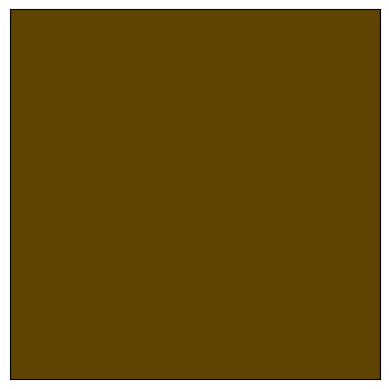

In [6]:
def rgb_display(rgb_value):
        
    img = np.array([[rgb_value,rgb_value],[rgb_value, rgb_value]])
        
    plt.imshow(img)
        
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
        
    plt.show()    
rgb_display(rgb_array[0][0])

This function is designed to run predictions, and return the predicted values for each inputted rgb value.

In [7]:
def knn_predict(knn, rgb_values):
    
    predict_list = []
    for value in rgb_values:
        
        predicted = knn.predict([value[0]])
        predicted = np.array2string(predicted)
        predicted = re.sub('[^\w\s]', '', predicted)
        
        predict_list.append(predicted)
        
    return predict_list
    
predictions = knn_predict(knn, rgb_array)

This function will be beneficial for our stats comparison, so we can report data, by comparing true vs. predicted values.

In [8]:
def actual_names(rgb_values):
    correct_values = []
    for index in rgb_values:
        value = df._get_value(index[1], 'colour_name')
        correct_values.append(value)
        
    return correct_values

true = actual_names(rgb_array)

This function runs the 4 important statistics for the model, saving them so that they can be analyzed later.

In [9]:
def stats_comparison(predictions, correct_values, show_values=True):
    
    
    accuracy = metrics.accuracy_score(correct_values, predictions)
    recall = metrics.recall_score(correct_values, predictions, average='weighted', zero_division=0)
    precision = metrics.precision_score(correct_values, predictions, average='weighted', zero_division=0)
    f1_score = metrics.f1_score(correct_values, predictions, average='weighted', zero_division=0)

    report = accuracy, recall, precision, f1_score
    if show_values == True:
        print("Weighted accuracy score:", accuracy)
        print("Weighted recall score:", recall)
        print("Weighted Precision Score:", precision)
        print("Weighted F1 Score:", f1_score)
        print()
    if show_values == False:
        return report
    
    return report

test = stats_comparison(predictions, true)

Weighted accuracy score: 0.2
Weighted recall score: 0.2
Weighted Precision Score: 0.13333333333333333
Weighted F1 Score: 0.15



In [10]:
def additional_info(predicted, true, df):
    # This function has to gather the frequency of the actual name for a certain color in the dataset, as well as 
    # gathering the accuracy of the certain color for each k-value iteration of the model.
    # This is for the purposes of the scatterplot visualization.

    the_accuracy = {}
    true_name_predictions = {}
    for idx in range(len(predicted)):
        
        if true[idx] not in true_name_predictions:
            true_name_predictions[true[idx]] = []
        if predicted[idx] not in true_name_predictions[true[idx]]:
            true_name_predictions[true[idx]].append(predicted[idx])
        
        if true[idx] not in the_accuracy:
            the_accuracy[true[idx]] = 0
        if predicted[idx] == true[idx]:
            the_accuracy[true[idx]] += 1
    
    # Frequency of a color name within the dataset
    
    counts = df['colour_name'].value_counts()

    name_counts = {}

    for name in true:

        name_counts[name] = counts.loc[[name]].to_list()[0]

    return (the_accuracy, name_counts, true_name_predictions)

This is an important function of alice, designed to return the report on the predicted values, as well as the additional information. It is designed to be modifiable, so that the user can choose to show displays for each color, as well as the statistics. The parameters are also passed to the functions run within the function, so that the code can be seamlessly integrated.

Statistics for knn-model, k = 500:

Weighted accuracy score: 0.2
Weighted recall score: 0.2
Weighted Precision Score: 0.05833333333333333
Weighted F1 Score: 0.09

Here is a display of some of the test colours, as well as their 'k = 500' predicted names, and actual names!

Predicted Name: brown, Actual Name: brown, Color:


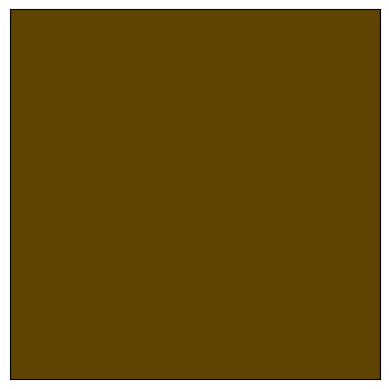

Predicted Name: brown, Actual Name: dogshit, Color:


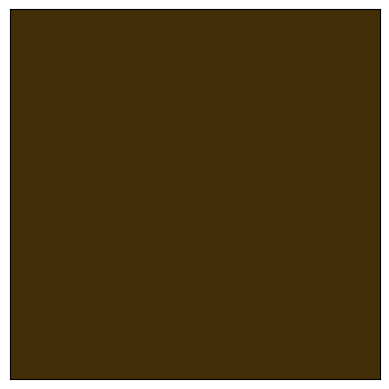

Predicted Name: brown, Actual Name: sienna, Color:


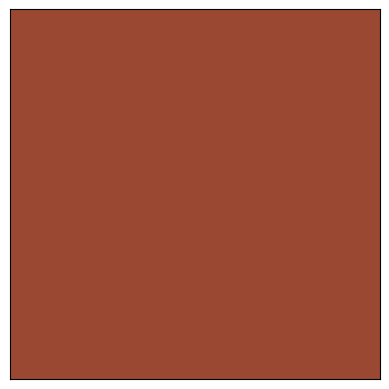

((0.2, 0.2, 0.05833333333333333, 0.09),
 ({'brown': 1,
   'dogshit': 0,
   'sienna': 0,
   'green': 0,
   'brown maroon': 0,
   'violet': 0,
   'mint': 0,
   'light grey': 0,
   'fuchsia': 0,
   'pink': 1},
  {'brown': 112,
   'dogshit': 1,
   'sienna': 5,
   'green': 207,
   'brown maroon': 1,
   'violet': 88,
   'mint': 5,
   'light grey': 22,
   'fuchsia': 37,
   'pink': 236},
  {'brown': ['brown'],
   'dogshit': ['brown'],
   'sienna': ['brown'],
   'green': ['turquoise'],
   'brown maroon': ['brown'],
   'violet': ['lilac'],
   'mint': ['grey'],
   'light grey': ['pink'],
   'fuchsia': ['pink'],
   'pink': ['pink']}))

In [11]:
def alice_computation(data, colors, N=3, display = False, display_size = 3, show_stats=True):
    
    diff_df = data_separator(data, colors)
    knn = training_data(diff_df, colors, n=N)
    actual = actual_names(colors)
    predictions = knn_predict(knn, colors)
    if show_stats == True:
        print(f"Statistics for knn-model, k = {N}:\n")
    test = stats_comparison(predictions, actual, show_values=show_stats)
    stuff = additional_info(predictions, actual, data)
    if display == True:
        
        print(f"Here is a display of some of the test colours, as well as their 'k = {N}'"
              " predicted names, and actual names!\n")
        idx = 0
        for color in colors[0:display_size]:
            print(f"Predicted Name: {predictions[idx]}, Actual Name: {actual[idx]}, Color:")
            rgb_display(color[0])
            idx += 1
    
    return (test, stuff)
        
alice_computation(df, rgb_array, N=500, display = True)

This is the bar plot visualizer that is run after alice computation, designed to show the differences in report values for each k value.

In [12]:
def knn_visualize(aggregate_report):
    aggregate_report.plot(kind="bar")
    plt.title('KNN-Model Statistics by k-values')
    plt.xticks(rotation=45)
    plt.xlabel('k-value for KNN')
    plt.ylabel('Weighted Scores')
    plt.show()

In [13]:
# Purposes of KNN Scatter:
# Plot every test color against some x and y value, and give each plot it's unique color and predicted name.
# X value: Frequency of the Actual Name in the Dataset and Name
# Y value: Accuracy of the KNN Model, computed as Correct Predictions/Total Predictions

def knn_scatter(extra_statistics):
    total_runs = len(extra_statistics)
    all_predicted_names = {}
    total_accuracies = Counter({})
    total_name_counts = Counter({})

    for tup in extra_statistics:
        total_accuracies.update(Counter(tup[0]))
        total_name_counts.update(Counter(tup[1]))
        
        for true_name in tup[2].keys():
            if true_name not in all_predicted_names:
                all_predicted_names[true_name] = []
            for pred_name in tup[2][true_name]:
                if pred_name not in all_predicted_names[true_name]:
                    all_predicted_names[true_name].append(pred_name)
    
    total_accuracies = dict(total_accuracies)
    total_name_counts = dict(total_name_counts)
    
    total_accuracies = {k: v / total_runs for k, v in total_accuracies.items()}
    
    total_dict = {}
    for color_name_acc in total_accuracies.keys():
        for color_name_co in total_name_counts.keys():
            if color_name_acc == color_name_co:
                total_dict[color_name_acc] = (total_name_counts[color_name_co], total_accuracies[color_name_acc], 
                                              all_predicted_names[color_name_acc])

    x_values_occurrence = []
    y_values = []
    
    for idx, y_value in enumerate(y_values):
        if y_value > 1:
            y_values[idx] = 1
    
    for tup in list(total_dict.values()):
        x_values_occurrence.append(tup[0])
        y_values.append(tup[1])
        
    x_values = list(total_dict.keys())
    
    for idx, name in enumerate(x_values):
        x_values[idx] = name + " :" + str(x_values_occurrence[idx])
    
    plt.figure(figsize=(14,6))
    plt.scatter(x_values, y_values)
    plt.xticks(rotation=45)
    plt.title("Weight of True Color Names and Occurrences with Accuracy of KNN")
    plt.xlabel("Actual Color Name and Occurrences in Dataset")
    plt.ylabel("Accuracy of all KNN models")
    for i, txt in enumerate(total_dict.values()):
        plt.text(x_values[i], y_values[i], txt[2], rotation = 45, fontsize='xx-small')
    
    print("Note: Point Labels are all of the predicted names for the colors for k = 1 through 12")
    plt.show()
    
    return all_predicted_names

The alice graph class is designed to consolidate much information, allowing the data run in earlier segments to become integrated with the class. This will make it easier to run further visualizations and run necessary computations.

In [14]:
class alice_graph:
    
    # We add the network graph as an attribute so it can easily be run within the alice_graph class.
    def __init__(self):
        """ Class constructor """
        self.g = nx.Graph()

    # The centroids function is aptly named, calculating the centroids of the accumulated predicted names for 
    # each color for every k-value.
    def centroids(self, predicted_names, rgb_values, df):
        
        pred = list(predicted_names.values())
        
        rgb_euclid = {}
        
        for tup in rgb_values:
            name = df._get_value(tup[1], 'colour_name')

            rgb_euclid[name] = tuple(tup[0])
        
        pred_centroids = {}
        for names in pred:
            for name in names:
                row = df.loc[df['colour_name'] == name]
                centroid = (sum(row['R'].astype(int))/len(row['R']), sum(row['G'].astype(int))/len(row['G']), sum(row['B'].astype(int))/len(row['B']))
            
                if name not in pred_centroids:
                    pred_centroids[name] = centroid
        
        return (rgb_euclid, pred_centroids)
    
    # This will give us the euclid distances between every colour and predicted name. Useful for our bar graph.
    def euclid_distances(self, predicted_names, euclid_data):
        
        distance_info = []
        for name, preds in predicted_names.items():
            for pred_name in preds:
                dst = distance.euclidean(euclid_data[0][name], euclid_data[1][pred_name])
                info = (name, pred_name, dst)
                distance_info.append(info)
                        
        return distance_info
    
    # Plots the distance between true and predicted names as a bar graph. Values of 0 mean that the colors are
    # essentially 'synonyms'
    def bar(self, distance_information):
        
        x_values = []
        y_values = []
        for tup in distance_information:
            x_value = f"Distance between {tup[0]} and {tup[1]}"
            x_values.append(x_value)
            y_values.append(tup[2])
        plt.figure(figsize=(14,6))
        plt.bar(x_values, y_values)
        plt.xticks(rotation=90, fontsize='xx-small')
        plt.title('Distances between Test Colors and Centroids')
        plt.xlabel('Color Comparison')
        plt.ylabel('Euclidean Distance between Test Colors and Centroids')
        plt.show()
        pass
    
    # We use the network library so we can create a weighted graph visualizing the relationship between 
    # predicted and true values.
    def graph(self, distance_information):
        
        for tup in distance_information:
            self.g.add_edge(tup[0], tup[1], weight=round(tup[2], 2))
        esmall = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] >= 0]

        pos=nx.fruchterman_reingold_layout(self.g, k=.99999999, iterations=1)

        nx.draw_networkx_nodes(self.g, pos, node_size=7, alpha=0.2)

        nx.draw_networkx_edges(
            self.g, pos, edgelist=esmall, width=1, alpha=0.2, edge_color="b", style="dashed"
        )

        nx.draw_networkx_labels(self.g, pos, font_size=5, font_family="sans-serif", alpha=1)

        edge_labels = nx.get_edge_attributes(self.g, "weight")
        nx.draw_networkx_edge_labels(self.g, pos, edge_labels, font_size=5)
    
        ax = plt.gca()
        ax.margins(0.08)
        plt.axis("off")
        plt.tight_layout()
        plt.figure(figsize=(20,6))
        plt.show()  

Lastly, Alice is the overall function, combining all of our individual functions with a level of modification ability so that we can alter the inputs and outputs, easily (Though for the purposes of this demonstration, they are left unmodified). This runs all of the above functions.

Hello! I'm Alice, and I'm here to show you some tips to help understand colors in the English Language.
To do this, we're going to be making use of a predictive model to identify colors!
Here is a display of some of the test colours, as well as their 'k = 12' predicted names, and actual names!

Predicted Name: cyan, Actual Name: light turquoise, Color:


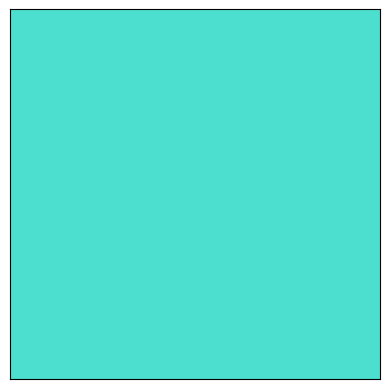

Predicted Name: purple, Actual Name: dark purple, Color:


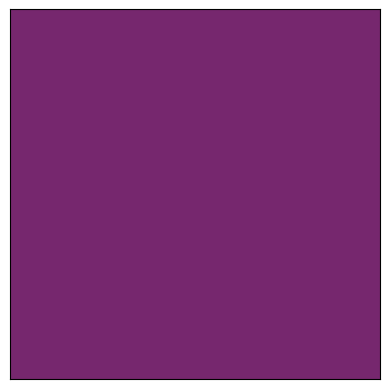

Predicted Name: purple, Actual Name: mauve, Color:


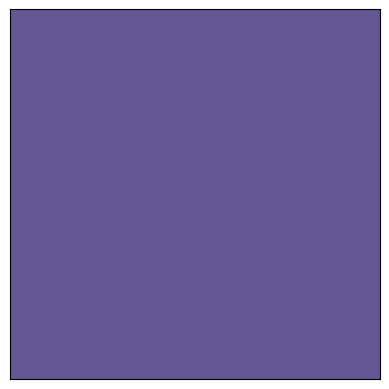

Here is the reports on accuracy of color predictions for each k-value of the model!
        Weighted Accuracy  Weighted Recall  Weighted Precision  \
k-size                                                           
1                     0.0              0.0                 0.0   
2                     0.1              0.1                 0.1   
3                     0.1              0.1                 0.1   
4                     0.2              0.2                 0.2   
5                     0.1              0.1                 0.1   
6                     0.1              0.1                 0.1   
7                     0.1              0.1                 0.1   
8                     0.1              0.1                 0.1   
9                     0.1              0.1                 0.1   
10                    0.1              0.1                 0.1   
11                    0.1              0.1                 0.1   
12                    0.1              0.1                

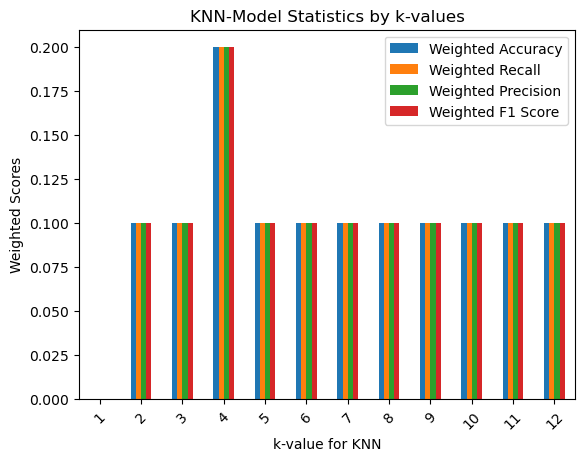

And here's an interesting graph to provide some more context!
Note: Point Labels are all of the predicted names for the colors for k = 1 through 12


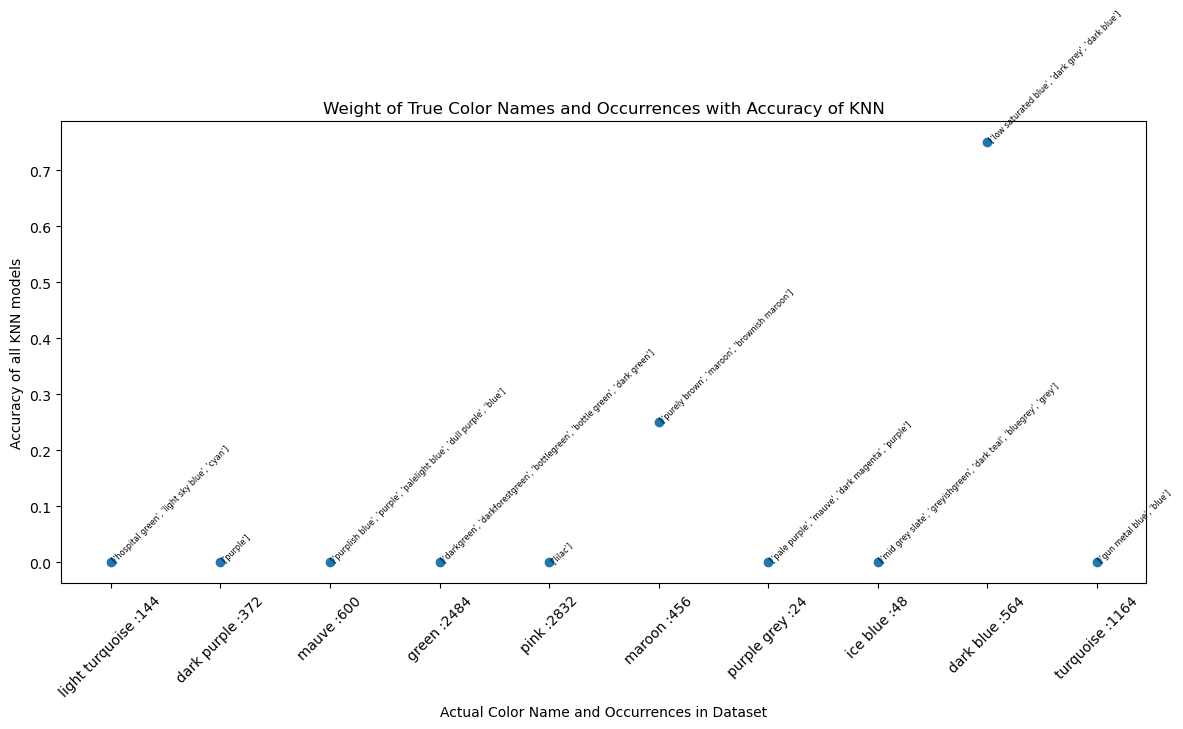

This is a bar graph marking the distances between color names and their synonyms!


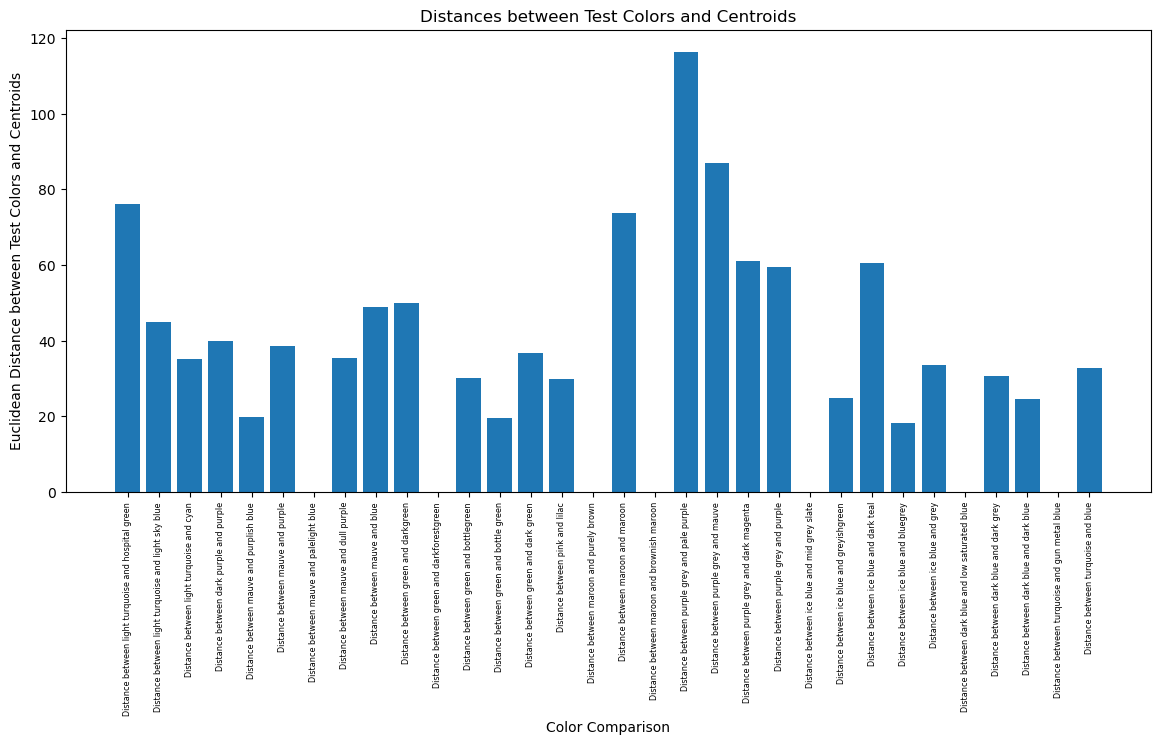

Here is the visualized distances of each color!


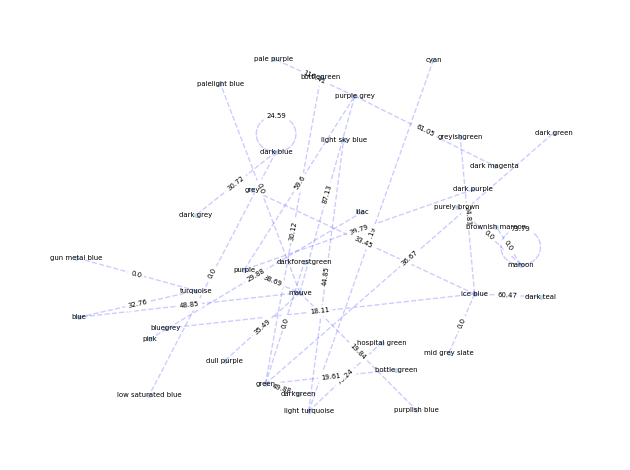

<Figure size 2000x600 with 0 Axes>

Thanks for participating with me! I hope you learned a lot!


In [15]:
def alice():
    print("Hello! I'm Alice, and I'm here to show you some tips to help understand colors in the English Language.")
    print("To do this, we're going to be making use of a predictive model to identify colors!")
    
    df = create_df('colour_naming_data-1.csv')
    values = rng_pull(df, N=10)
    
    data = []
    xtra_stats = []
    for n in range(1, 13):
        if n == 12:
            knn = alice_computation(df, values, N=n, display=True, show_stats=False)
            data.append(knn[0])
            xtra_stats.append(knn[1])
            break
        knn = alice_computation(df, values, N=n, show_stats=False)
        data.append(knn[0])
        xtra_stats.append(knn[1])
    
    aggregate = pd.DataFrame(data, columns=['Weighted Accuracy', 'Weighted Recall', 
                                            'Weighted Precision', 'Weighted F1 Score'])
    aggregate.index += 1
    aggregate.index.name = 'k-size'
    
    print("Here is the reports on accuracy of color predictions for each k-value of the model!")
    print(aggregate)
    
    print("Here is a visual of that report!")
    knn_visualize(aggregate)
    
    print("And here's an interesting graph to provide some more context!")
    pred_names = knn_scatter(xtra_stats)
    
    graph = alice_graph()
    prep = graph.centroids(pred_names, values, df)
    euclids = graph.euclid_distances(pred_names, prep)
    
    print("This is a bar graph marking the distances between color names and their synonyms!")
    graph.bar(euclids)
    
    print("Here is the visualized distances of each color!")
    graph.graph(euclids)
    
    print("Thanks for participating with me! I hope you learned a lot!")
    
alice()

# Reflection

There were numerous challenges and insights I faced and learned in doing this project. Firstly and perhaps most difficult was the sheer task of creating the amount of functions I had to create, and then later remodifying every one whenever there would be a new function necessary. At a certain point this can get overwhelming to navigate if you aren't in full control of what you're doing.

Secondly, I'll admit that the tasks given in the rubric were quite confusing. I chose to interpret certain components to what I felt were the most logical tasks to implement, and I believe that I did a decent job at this.  That level of freedom could both be beneficial in its freedom as well as paradoxically somewhat limiting, as I was simultaneously able to take any degree of approaches to the project as I liked (which I most certainly did, though all the discarded code and functions can't be included in this project) but also limited by confusion over what my task should be.

As far as the specifics of the project go, there were several difficulties to face. Making functions that could simultaneously output information to the user and return data to the program could be difficult, as many times as the numbers of functions expanded there would be a need to return to older functions to update data-storage methods. There was also a large degree of confusion on utilizing the NetworkX library, as the library shows a very rigid approach to implementation that could be a difficult initial adjustment.

To conclude, while the scale of the project caused difficulty in terms of implementing a large variety of functions, it gave me a valuable insight into how Machine-Learning Algorithms work on a practical level, allowing me to form my own empirical reasoning as to why certain k-values may have been better, largely contributing to a greater understanding of the intracacies of how data-modeling works in the data science world.